<a href="https://colab.research.google.com/github/HarinduR/FeatherFind/blob/Keyword-Bird-Finder/FeatherFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
from spacy.matcher import Matcher
from spacy.util import filter_spans
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")

COLOR_SYNONYMS = {
    "azure": "blue", "crimson": "red", "scarlet": "red",
    "emerald": "green", "ivory": "white", "charcoal": "black"
}

HABITAT_TERMS = ["forest", "wetland", "desert", "water", "mountains", "grassland", "marsh", "coast"]
SIZE_TERMS = ["small", "large", "tiny", "big", "medium", "giant"]
CONTINENTS = ["asia", "europe", "africa", "america", "australia", "antarctica"]
DIRECTIONS = ["north", "south", "east", "west"]

def extract_features_optimized(text):
    doc = nlp(text.lower())
    features = {
        "size": None,
        "color": {"primary": None, "secondary": None},
        "habitat": None,
        "region": None,
        "diet": None,
        "eyes": {"size": None, "color": None},
        "beak": {"size": None, "color": None},
        "legs": {"size": None, "color": None},
        "feathers": None
    }

    for token in doc:
        if token.dep_ == "amod" and token.head.text == "bird" and token.text in SIZE_TERMS:
            features["size"] = token.text

        if token.dep_ == "amod" and token.head.text in ["feathers", "wings", "chest", "body", "plumage", "tail"]:
            compound_color = None
            for child in token.head.children:
                if child.dep_ == "compound":
                    compound_color = COLOR_SYNONYMS.get(child.text, child.text)
                    break

            color = compound_color if compound_color else COLOR_SYNONYMS.get(token.text, token.text)

            if not features["color"]["primary"]:
                features["color"]["primary"] = color
            else:
                features["color"]["secondary"] = color

        if token.dep_ == "amod" and token.head.text == "bird" and token.text not in SIZE_TERMS:
            color = COLOR_SYNONYMS.get(token.text, token.text)
            if not features["color"]["primary"]:
                features["color"]["primary"] = color

        if token.dep_ == "amod" and token.children != "" and token.head.text in ["feathers", "wings", "chest", "body", "plumage", "tail", "bird"] and token.text not in SIZE_TERMS:
          for child in token.children:
            if child.dep_ == "conj":
              color = COLOR_SYNONYMS.get(child.text, child.text)
              features['color']['secondary'] = color

    matcher = Matcher(nlp.vocab)

    matcher.add("HABITAT", [
        [{"LOWER": {"IN": ["in", "near", "around", "found"]}},
         {"LOWER": {"IN": HABITAT_TERMS}}]
    ])

    matcher.add("REGION", [
        [
            {"LOWER": {"IN": ["in", "from", "found"]}},
            {"LOWER": {"IN": DIRECTIONS}, "OP": "*"},
            {"LOWER": {"IN": CONTINENTS}}
        ]
    ])

    matcher.add("DIET", [
        [{"LOWER": {"IN": ["eats", "feeds", "consumes", "diet"]}},
         {"POS": "NOUN"}]
    ])

    matcher.add("PHYSICAL_CHARACTERISTICS", [
        [
            {"POS": {"IN": ["ADV", "ADJ", "NUM"]}, "OP": "*"},
            {"POS": {"IN": ["ADJ", "NUM"]}, "OP": "+"},
            {"LOWER": {"IN": ["eyes", "beak", "bill", "legs"]}}
        ]
    ])

    matches = matcher(doc)
    spans = []

    if not Span.has_extension("match_label"):
        Span.set_extension("match_label", default=None)

    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        span._.match_label = label
        spans.append(span)

    filtered_spans = filter_spans(spans)

    for span in filtered_spans:
        label = span._.match_label
        text = span.text
        if label == "HABITAT":
            features["habitat"] = span[-1].text
        elif label == "REGION":
            features["region"] = span[1:].text
        elif label == "DIET":
            features["diet"] = span[-1].text
        elif label == "PHYSICAL_CHARACTERISTICS":
            if (len(span) >= 2):
              words = text.split()
              category = words[-1]
              for word in words[0:-1]:
                if word in SIZE_TERMS:
                  features[category]["size"] = word
                else:
                  features[category]["color"] = COLOR_SYNONYMS.get(word, word)

    return features

example_text = "giant bird with green body and azure feathers. black large beak. lives in water and eats crabs. this bird was seen in south asia. also it had  blue eyes "
example_text2 = "blue and green bird"
features = extract_features_optimized(example_text)
print(features)


{'size': 'giant', 'color': {'primary': 'green', 'secondary': None}, 'habitat': 'water', 'region': 'south asia', 'diet': 'crabs', 'eyes': {'size': None, 'color': 'blue'}, 'beak': {'size': 'large', 'color': 'black'}, 'legs': {'size': None, 'color': None}, 'feathers': None}


Enhanced code given by chatgpt

In [2]:
#More enhancements

import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Span
from spacy.util import filter_spans
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

nlp = spacy.load("en_core_web_sm")

# Enhanced color synonyms and compound colors
COLOR_SYNONYMS = {
    "azure": "blue", "crimson": "red", "scarlet": "red", "emerald": "green",
    "ivory": "white", "charcoal": "black", "cerulean": "blue", "sapphire": "blue",
    "ruby": "red", "vermilion": "red", "olive": "green", "sky-blue": "blue",
    "black-tipped": "black", "yellowish-brown": "brown", "navy-blue": "blue"
}

HABITAT_TERMS = ["forest", "wetland", "desert", "water", "mountains", "grassland",
                "marsh", "coast", "rainforest", "tundra", "savanna"]
SIZE_TERMS = ["small", "large", "tiny", "big", "medium", "giant", "sized"]
CONTINENTS = ["asia", "europe", "africa", "america", "australia", "antarctica"]
DIRECTIONS = ["north", "south", "east", "west", "central", "southeast", "northwest"]
BODY_PARTS = {"eyes", "beak", "wings", "legs", "feathers", "plumage", "chest", "tail"}

def is_negated(token):
    """Check if a modifier is negated"""
    return any(child.dep_ == "neg" for child in token.head.children)

def extract_features(text):
    doc = nlp(text.lower())

    features = {
        "size": [],
        "color": {"primary": [], "secondary": []},
        "habitats": [],
        "regions": [],
        "diet": [],
        "eyes": {"size": [], "color": []},
        "beak": {"size": [], "color": []},
        "legs": {"size": [], "color": []},
        "feathers": {"color": []},
        "negations": []
    }

    # Dependency parsing for colors and sizes
    for token in doc:
        # Handle negations
        if token.dep_ == "neg":
            features["negations"].append(token.head.text)

        # Size detection
        if token.text in SIZE_TERMS and token.head.text == "bird" and not is_negated(token):
            features["size"].append(token.text)

        # Color detection with compound handling
        if token.dep_ == "amod" and token.head.text in ["feathers", "wings", "body", *BODY_PARTS]:
            if is_negated(token):
                continue

            color = None
            # Check for compound colors ("black-tipped")
            for child in token.children:
                if child.dep_ == "compound":
                    color = COLOR_SYNONYMS.get(f"{child.text}-{token.text}",
                            COLOR_SYNONYMS.get(child.text, child.text))
                    break

            color = color or COLOR_SYNONYMS.get(token.text, token.text)
            target = "primary" if not features["color"]["primary"] else "secondary"
            features["color"][target].append(color)

    # Initialize matchers
    matcher = Matcher(nlp.vocab)
    phrase_matcher = PhraseMatcher(nlp.vocab)

    # Habitat matching with PhraseMatcher
    habitat_patterns = [nlp.make_doc(text) for text in HABITAT_TERMS]
    phrase_matcher.add("HABITAT", habitat_patterns)

    # Region patterns
    matcher.add("REGION", [
        [{"LOWER": {"IN": ["in", "from", "found"]}},
         {"LOWER": {"IN": DIRECTIONS}, "OP": "*"},
         {"LOWER": {"IN": CONTINENTS}, "OP": "+"}]
    ])

    # Diet patterns
    matcher.add("DIET", [
        [ # Pattern 1: "eats fish and crustaceans"
            {"LOWER": {"IN": ["eats", "feeds", "diet"]}},
            {"LOWER": "on", "OP": "?"},  # Optional "on"
            {"POS": "NOUN", "OP": "+"},  # Require at least 1 noun
            {"LOWER": "and", "OP": "*"}, # Optional conjunctions
            {"POS": "NOUN", "OP": "*"}   # Additional nouns
        ]
    ])

    # Physical characteristics with measurement support
    matcher.add("PHYSICAL", [
        [{"ENT_TYPE": "QUANTITY", "OP": "?"},  # Capture measurements
         {"POS": {"IN": ["ADJ", "ADV"]}, "OP": "+"},
         {"LOWER": {"IN": list(BODY_PARTS)}}]
    ])

    # Compound colors
    matcher.add("COMPOUND_COLOR", [
        [{"LOWER": {"REGEX": "^(sky|navy|royal|black|white|yellowish)"}},
         {"LOWER": {"REGEX": "^(blue|brown|tipped|striped|edged)$"}}]
    ])

    # Run matchers
    matches = matcher(doc) + phrase_matcher(doc)
    spans = []
    for match_id, start, end in matches:
        label = nlp.vocab.strings[match_id]
        span = doc[start:end]
        Span.set_extension("match_label", default=label, force=True)
        span._.match_label = label
        spans.append(span)

    filtered_spans = filter_spans(spans)

    # Process matches
    for span in filtered_spans:
        label = span._.match_label
        text = span.text.lower()

        if label == "HABITAT":
            features["habitats"].append(span.text)
        elif label == "REGION":
            region = " ".join([t.text for t in span if t.text in CONTINENTS + DIRECTIONS])
            features["regions"].append(region)
        elif label == "DIET":
            diet_items = [t.text for t in span if t.pos_ in ["NOUN", "PROPN"]]
            features["diet"].extend(diet_items)
        elif label == "PHYSICAL":
            body_part = span[-1].text
            modifiers = [t.text for t in span[:-1]]

            for mod in modifiers:
                if mod in SIZE_TERMS:
                    features[body_part]["size"].append(mod)
                else:
                    color = COLOR_SYNONYMS.get(mod, mod)
                    features[body_part]["color"].append(color)
        elif label == "COMPOUND_COLOR":
            color = "-".join([t.text for t in span])
            normalized = COLOR_SYNONYMS.get(color, color.split("-")[0])
            features["color"]["secondary"].append(normalized)

    # Extract regions using NER
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            features["regions"].append(ent.text)

    # Post-processing to remove duplicates
    for key in features:
        if isinstance(features[key], dict):
            for subkey in features[key]:
                features[key][subkey] = list(set(features[key][subkey]))
        else:
            features[key] = list(set(features[key]))

    return features

# Test the enhanced version
test_text = (
    "giant bird with green body and sky-blue feathers, black-tipped large beak, "
    "lives in coastal wetlands and eats crabs, found in southeast asia but not in africa, "
    "with pale yellow eyes measuring 2.5 cm."
)

result = extract_features(test_text)
print("Enhanced Extraction Results:")
for category, data in result.items():
    print(f"{category.upper():<12} {data}")

Enhanced Extraction Results:
SIZE         ['giant']
COLOR        {'primary': ['green'], 'secondary': ['large', 'yellow', 'blue', 'tipped']}
HABITATS     []
REGIONS      ['southeast asia', 'africa']
DIET         ['crabs']
EYES         {'size': [], 'color': ['pale', 'yellow']}
BEAK         {'size': ['large'], 'color': []}
LEGS         {'size': [], 'color': []}
FEATHERS     {'color': ['blue']}
NEGATIONS    ['in']


In [5]:
import spacy
from spacy.matcher import Matcher
from spacy.util import filter_spans
from spacy.tokens import Span

class FeatureExtractor:

    def __init__(self):

        self.nlp = spacy.load("en_core_web_sm")

        self.COLOR_SYNONYMS = {
            "azure": "blue", "crimson": "red", "scarlet": "red",
            "emerald": "green", "ivory": "white", "charcoal": "black"
        }

        self.HABITAT_TERMS = ["forest", "wetland", "desert", "water", "mountains", "grassland", "marsh", "coast", "open field", "water body", "woodland"]
        self.SIZE_TERMS = ["small", "large", "tiny", "big", "medium", "giant"]
        self.CONTINENTS = ["asia", "europe", "africa", "america", "australia", "antarctica"]
        self.DIRECTIONS = ["north", "south", "east", "west"]
        self.BEAK_SHAPES = ["curved", "spare", "long", "short", "thick"]

    def extractFeatures(self, text):
        doc = self.nlp(text.lower())
        features = {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": None,
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None},
        }

        for token in doc:
            if token.dep_ == "amod" and token.head.text == "bird" and token.text in self.SIZE_TERMS:
                features["size"] = token.text

            if token.dep_ == "amod" and token.head.text in ["feathers", "wings", "chest", "body", "plumage", "tail"]:
                compound_color = None
                for child in token.head.children:
                    if child.dep_ == "compound":
                        compound_color = self.COLOR_SYNONYMS.get(child.text, child.text)
                        break

                color = compound_color if compound_color else self.COLOR_SYNONYMS.get(token.text, token.text)

                if not features["color"]["primary"]:
                    features["color"]["primary"] = color
                else:
                    features["color"]["secondary"] = color

            if token.dep_ == "amod" and token.head.text == "bird" and token.text not in self.SIZE_TERMS:
                color = self.COLOR_SYNONYMS.get(token.text, token.text)
                if not features["color"]["primary"]:
                    features["color"]["primary"] = color

            if token.dep_ == "amod" and token.children != "" and token.head.text in ["feathers", "wings", "chest", "body", "plumage", "tail", "bird"] and token.text not in self.SIZE_TERMS:
                for child in token.children:
                    if child.dep_ == "conj":
                        color = self.COLOR_SYNONYMS.get(child.text, child.text)
                        features['color']['secondary'] = color

        matcher = Matcher(self.nlp.vocab)  # Use self.nlp

        matcher.add("HABITAT", [
            [{"LOWER": {"IN": ["in", "near", "around", "found"]}},
            {"LOWER": {"IN": self.HABITAT_TERMS}}]
        ])

        matcher.add("REGION", [
            [
                {"LOWER": {"IN": ["in", "from", "found"]}},
                {"LOWER": {"IN": self.DIRECTIONS}, "OP": "*"},
                {"LOWER": {"IN": self.CONTINENTS}}
            ]
        ])

        matcher.add("DIET", [
            [{"LOWER": {"IN": ["eats", "feeds", "consumes", "diet"]}},
            {"POS": "NOUN"}]
        ])

        matcher.add("PHYSICAL_CHARACTERISTICS", [
            [
                {"POS": {"IN": ["ADV", "ADJ", "NUM"]}, "OP": "*"},
                {"POS": {"IN": ["ADJ", "NUM"]}, "OP": "+"},
                {"LOWER": {"IN": ["eyes", "beak", "bill", "legs"]}}
            ]
        ])

        matcher.add("BEAK_SHAPE", [
            [
                {"LOWER": {"IN": self.BEAK_SHAPES}},
                {"POS": {"IN": ["ADJ", "NUM"]}, "OP": "*"},
                {"LOWER": {"IN": ["beak", "bill"]}}
            ],
            [
                {"POS": {"IN": ["ADJ", "NUM"]}, "OP": "*"},
                {"LOWER": {"IN": self.BEAK_SHAPES}},
                {"LOWER": {"IN": ["beak", "bill"]}}
            ]
        ])

        matches = matcher(doc)
        spans = []

        if not Span.has_extension("match_label"):
            Span.set_extension("match_label", default=None)

        for match_id, start, end in matches:
            label = self.nlp.vocab.strings[match_id]
            span = doc[start:end]
            span._.match_label = label
            spans.append(span)

        filtered_spans = filter_spans(spans)

        for span in filtered_spans:
            label = span._.match_label
            text = span.text
            if label == "HABITAT":
                features["habitat"] = span[-1].text
            elif label == "REGION":
                features["region"] = span[1:].text
            elif label == "DIET":
                features["diet"] = span[-1].text
            # In the PHYSICAL_CHARACTERISTICS block:
            elif label == "PHYSICAL_CHARACTERISTICS":
                if len(span) >= 2:
                    words = text.split()
                    category = words[-1]
                    # Map "bill" to "beak"
                    category = "beak" if category == "bill" else category  # Add this line
                    for word in words[:-1]:
                        if word in self.SIZE_TERMS:
                            features[category]["size"] = word
                        elif word not in self.BEAK_SHAPES:
                            features[category]["color"] = self.COLOR_SYNONYMS.get(word, word)
            elif label == "BEAK_SHAPE":
                # Extract words from the span (more reliable than splitting text)
                words = [token.text for token in span]
                # Check if the last word is "bill" and map to "beak"
                target_category = "beak" if words[-1] == "bill" else words[-1]
                for word in words[:-1]:
                    if word in self.BEAK_SHAPES:
                        features["beak"]["size"] = word
                    else:
                        features["beak"]["color"] = self.COLOR_SYNONYMS.get(word, word)
        return features




In [4]:
#Dataset

dataset = [
    #1
    {
        "prompt": "The small blue bird was found in forest and eats worms.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #2
    {
        "prompt": "A crimson bird with scarlet chest feathers was seen near the wetland, and it feeds insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": "red"},
            "habitat": "wetland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #3
    {
        "prompt": "The bird with emerald wings and tiny beak was found in north america and consumes seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #4
    {
        "prompt": "A big bird with ivory tail and curved bill was spotted from east asia; it eats fish.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #5
    {
        "prompt": "The bird with large, charcoal wings and tiny legs was found near the desert and feeds seeds.",
        "expected_features": {
            "size": None,  # 'large' modifies wings instead of bird directly
            "color": {"primary": "black", "secondary": None},  # charcoal converts to black
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #6
    {
        "prompt": "The small blue bird was found in forest and eats worms.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #7
    {
        "prompt": "A crimson bird with scarlet chest feathers was seen near the wetland, and it feeds insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": "red"},
            "habitat": "wetland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #8
    {
        "prompt": "The bird with emerald wings and tiny beak was found in north america and consumes seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #9
    {
        "prompt": "A big bird with ivory tail and curved bill was spotted from east asia; it eats fish.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #10
    {
        "prompt": "The bird with large, charcoal wings and tiny legs was found near the desert and feeds seeds.",
        "expected_features": {
            "size": None,  # 'large' modifies wings rather than the bird directly
            "color": {"primary": "black", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #11
    {
        "prompt": "The medium green bird with blue eyes and a long beak roams in open field and eats berries.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": None},
            "habitat": "field",  # From "open field", the matcher picks the last token
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #12
    {
        "prompt": "A giant red bird with thick beak and big legs was found near woodland and consumes meat.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "woodland",
            "region": None,
            "diet": "meat",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #13
    {
        "prompt": "A tiny bird with azure feathers was spotted in the mountains and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},  # azure maps to blue
            "habitat": "mountains",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #14
    {
        "prompt": "Found from west europe, the bird with scarlet tail and spare bill feeds seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "from west europe",  # region extracted from the span excluding the first token
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #15
    {
        "prompt": "A medium bird with ivory wings and a short bill was found around marsh and eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #16
    {
        "prompt": "The bird has blue eyes and a large body with red plumage, found near the coast and feeds algae.",
        "expected_features": {
            "size": None,  # 'large' modifies body, not directly the bird
            "color": {"primary": "red", "secondary": None},
            "habitat": "coast",
            "region": None,
            "diet": "algae",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #17
    {
        "prompt": "A tiny bird with emerald plumage and tiny legs, found in water body, feeds fish.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": None},
            "habitat": "body",  # From "in water body" the matcher picks the last token
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #18
    {
        "prompt": "A large bird with charcoal legs and a spare beak was found from south africa and consumes worms.",
        "expected_features": {
            "size": "large",
            "color": {"primary": None, "secondary": None},
            "habitat": None,
            "region": "from south africa",
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": "black"}  # charcoal converts to black
        }
    },
    #19
    {
        "prompt": "The small bird with ivory chest feathers and blue eyes was observed around grassland and eats insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "white", "secondary": None},
            "habitat": "grassland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #20
    {
        "prompt": "A bird with no distinct features was seen in desert.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #21
    {
        "prompt": "The big crimson bird with ivory wings and spare bill was seen in east africa and consumes insects.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "red", "secondary": "white"},
            "habitat": None,
            "region": "east africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #22
    {
        "prompt": "A tiny azure bird with emerald eyes and a curved bill was spotted near open field and eats worms.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "field",  # matcher extracts the last token from "open field"
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": "green"},  # emerald maps to green
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #23
    {
        "prompt": "The giant scarlet bird with medium plumage was discovered in desert and feeds small rodents.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "rodents",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #24
    {
        "prompt": "A small bird with azure tail and big legs was seen in the coast and eats fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "coast",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #25
    {
        "prompt": "The medium bird with emerald eyes and ivory beak was spotted near marsh and consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": None, "color": "white"},
            "legs": {"size": None, "color": None}
        }
    },
    #26
    {
        "prompt": "A large bird with charcoal wings, scarlet chest, and tiny legs was observed in the mountains and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "black", "secondary": "red"},
            "habitat": "mountains",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #27
    {
        "prompt": "A bird with a spare beak, big legs, and thick eyes was found in desert and eats lizards.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": None, "color": None},  # 'thick' is in BEAK_SHAPES so not assigned for eyes
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #28
    {
        "prompt": "A medium bird with scarlet wings, emerald eyes, and a long bill was found in west europe and feeds nectar.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "west europe",
            "diet": "nectar",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #29
    {
        "prompt": "The bird with tiny legs and big eyes, found in the marsh, consumes seeds and insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "seeds",  # matcher likely catches the first noun after 'consumes'
            "eyes": {"size": "big", "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #30
    {
        "prompt": "A big bird with huge wings and a short bill was sighted from south america and eats fruit.",
        "expected_features": {
            "size": "big",
            "color": {"primary": None, "secondary": None},  # 'huge' is not in SIZE_TERMS and not mapped as color
            "habitat": None,
            "region": "south america",  # 'south' as direction and 'america' from CONTINENTS
            "diet": "fruit",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #31
    {
        "prompt": "A giant azure bird with charcoal chest feathers and spare beak was seen from north africa and feeds insects.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "blue", "secondary": "black"},
            "habitat": None,
            "region": "north africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #32
    {
        "prompt": "A medium bird with ivory wings, large eyes, and a long bill was spotted in desert and eats worms.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "worms",
            "eyes": {"size": "large", "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #33
    {
        "prompt": "The small bird with scarlet tail feathers and big legs was seen near the marsh and consumes fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "red", "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #34
    {
        "prompt": "A large bird with emerald plumage, tiny beak, and medium legs was found in east asia and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": "medium", "color": None}
        }
    },
    #35
    {
        "prompt": "A tiny bird with blue eyes and a short bill was observed around woodland and eats berries.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "woodland",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #36
    {
        "prompt": "A big bird with emerald wings and spare bill, found in south america, consumes seeds.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "south america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #37
    {
        "prompt": "The medium bird with ivory chest and blue eyes was seen near the grassland and eats insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "grassland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #38
    {
        "prompt": "A small bird with charcoal wings, big eyes, and a curved bill was discovered in open field and feeds fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "black", "secondary": None},
            "habitat": "field",  # 'open field' yields 'field'
            "region": None,
            "diet": "fish",
            "eyes": {"size": "big", "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #39
    {
        "prompt": "A giant bird with scarlet plumage, tiny legs, and a spare beak was spotted from west europe and consumes nectar.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "west europe",
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #40
    {
        "prompt": "A medium bird with emerald wings and ivory tail, found near the coast, eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "white"},
            "habitat": "coast",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #41.
    {
        "prompt": "A tiny bird with crimson wings, big beak, and medium legs, spotted in the open field, eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": None},
            "habitat": "field",  # from "open field" the matcher typically returns the final token
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "big", "color": None},
            "legs": {"size": "medium", "color": None}
        }
    },
    #42.
    {
        "prompt": "A large bird with azure plumage and spare bill was observed from west africa and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": None},  # azure maps to blue
            "habitat": None,
            "region": "west africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #43.
    {
        "prompt": "A medium bird with emerald tail and ivory chest feathers, found in open field, consumes worms.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "white"},  # emerald and ivory are mapped
            "habitat": "field",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #44.
    {
        "prompt": "The bird with small charcoal eyes and big beak was found near the desert and eats lizards.",
        "expected_features": {
            "size": None,  # no direct size descriptor for the bird
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": "small", "color": "black"},  # charcoal maps to black for eyes
            "beak": {"size": "big", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #45.
    {
        "prompt": "A giant bird with scarlet beak, medium legs, and tiny eyes was spotted from north america and consumes seeds.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": None, "secondary": None},  # no color modifier directly attached to bird
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": None, "color": "red"},  # scarlet maps to red for beak
            "legs": {"size": "medium", "color": None}
        }
    },
    #46.
    {
        "prompt": "A bird with no size description but with blue chest feathers and a long bill was seen in east europe and eats insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": "blue", "secondary": None},
            "habitat": None,
            "region": "east europe",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #47.
    {
        "prompt": "The small bird with a thick beak and big, charcoal legs was observed near the marsh and feeds fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "big", "color": "black"}  # charcoal converts to black
        }
    },
    #48.
    {
        "prompt": "A medium bird with ivory eyes, emerald plumage, and spare bill was found in south america and consumes crustaceans.",
        "expected_features": {
            "size": "medium",
            # Depending on processing order, one might be assigned as primary color.
            # Here, we assume the color from the plumage (emerald) becomes primary, and the ivory from eyes is secondary.
            "color": {"primary": "green", "secondary": "white"},
            "habitat": None,
            "region": "south america",
            "diet": "crustaceans",
            "eyes": {"size": None, "color": "white"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #49.
    {
        "prompt": "A tiny bird with blue chest feathers, big eyes, and short bill was seen in the forest and feeds insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "insects",
            "eyes": {"size": "big", "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #50.
    {
        "prompt": "A medium bird with crimson wings, tiny legs, and a long bill, found near the desert, consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #51.
    {
        "prompt": "A small bird with a golden crest, short tail, and a thin beak was seen in a tropical forest eating nectar.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "yellow", "secondary": None},  # golden maps to yellow
            "habitat": "forest",  # "tropical forest" matches "forest"
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thin", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #52.
    {
        "prompt": "A large, nocturnal bird with amber eyes, curved beak, and brown plumage hunts small mammals in Europe.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "brown", "secondary": None},
            "habitat": None,
            "region": "europe",
            "diet": "small mammals",
            "eyes": {"size": None, "color": "yellow"},  # amber maps to yellow
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #53.
    {
        "prompt": "A medium-sized water bird with a broad beak, webbed feet, and white plumage was spotted in a lake feeding on fish.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "lake",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "broad", "color": None},
            "legs": {"size": None, "color": None}  # Webbed feet is a trait, but doesn't describe size/color
        }
    },
    #54.
    {
        "prompt": "A tiny desert bird with a sandy brown back, long legs, and a slender bill eats insects and seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "brown", "secondary": None},  # sandy brown is still brown
            "habitat": "desert",
            "region": None,
            "diet": "insects and seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "slender", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #55.
    {
        "prompt": "A brightly colored bird with an iridescent green chest, deep blue wings, and a long, sharp beak was found in a rainforest eating berries.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": "blue"},
            "habitat": "rainforest",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #56.
    {
        "prompt": "A massive bird with jet black feathers, piercing yellow eyes, and a hooked beak hunts rodents in North America.",
        "expected_features": {
            "size": "massive",
            "color": {"primary": "black", "secondary": None},
            "habitat": None,
            "region": "north america",
            "diet": "rodents",
            "eyes": {"size": None, "color": "yellow"},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #57.
    {
        "prompt": "A tiny songbird with a short tail, pale yellow belly, and fine beak sings in gardens and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "yellow", "secondary": None},
            "habitat": "garden",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "fine", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #58.
    {
        "prompt": "A robust bird with a thick, powerful beak and speckled grey feathers was seen near a river feeding on grains.",
        "expected_features": {
            "size": "robust",
            "color": {"primary": "grey", "secondary": None},
            "habitat": "river",
            "region": None,
            "diet": "grains",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #59.
    {
        "prompt": "A medium-sized wading bird with bright orange legs, a long, thin bill, and spotted black-and-white feathers was observed in the wetlands consuming crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": "white"},
            "habitat": "wetlands",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "orange"}
        }
    },
    #60.
    {
        "prompt": "A small, tropical bird with a red cap, black body, and short wings nests in dense vegetation and eats fruit.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "black", "secondary": "red"},
            "habitat": "vegetation",
            "region": None,
            "diet": "fruit",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #61.
    {
        "prompt": "A huge sea bird with greyish-white feathers, webbed feet, and a long hooked beak was seen along the coast feeding on fish.",
        "expected_features": {
            "size": "huge",
            "color": {"primary": "white", "secondary": "grey"},
            "habitat": "coast",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #62
    {
        "prompt": "A tiny bird with a crimson throat, iridescent green back, and a sharp, needle-like beak was hovering near flowers sipping nectar.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": "red"},
            "habitat": "flower",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "sharp", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #63.
    {
        "prompt": "A massive black-and-white bird with a large, curved beak and long legs was striding through the African savanna hunting small reptiles.",
        "expected_features": {
            "size": "massive",
            "color": {"primary": "black", "secondary": "white"},
            "habitat": "savanna",
            "region": "africa",
            "diet": "small reptiles",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "large", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #64.
    {
        "prompt": "A medium-sized shorebird with speckled grey and white feathers, a long, slender beak, and dark legs was foraging along the beach for crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "grey", "secondary": "white"},
            "habitat": "shore",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "dark"}
        }
    },
    #65.
    {
        "prompt": "A huge, flightless bird covered in shaggy brown feathers was sprinting across the open plains of Australia.",
        "expected_features": {
            "size": "huge",
            "color": {"primary": "brown", "secondary": None},
            "habitat": "plains",
            "region": "australia",
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #66.
    {
        "prompt": "A bright orange and black bird with a forked tail was seen in an orchard feasting on ripe mangoes.",
        "expected_features": {
            "size": None,
            "color": {"primary": "orange", "secondary": "black"},
            "habitat": "orchard",
            "region": None,
            "diet": "mangoes",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #67.
    {
        "prompt": "A slender bird with a bright yellow belly, black wings, and an exceptionally long tail was seen darting through dense undergrowth.",
        "expected_features": {
            "size": "slender",
            "color": {"primary": "yellow", "secondary": "black"},
            "habitat": "dense undergrowth",
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #68.
    {
        "prompt": "A snow-white bird with piercing blue eyes, a short pointed beak, and powerful talons was circling above the icy tundra hunting hares.",
        "expected_features": {
            "size": None,
            "color": {"primary": "white", "secondary": None},
            "habitat": "tundra",
            "region": None,
            "diet": "hares",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #69.
    {
        "prompt": "A medium-sized parrot with vibrant green feathers, a red forehead, and a strong curved beak was cracking open nuts in the jungle canopy.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "red"},
            "habitat": "jungle",
            "region": None,
            "diet": "nuts",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "strong", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #70.
    {
        "prompt": "A small blue bird with a white underbelly and a thin beak was fluttering near a waterfall catching insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": "white"},
            "habitat": "waterfall",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thin", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #71
    {
        "prompt": "A tiny bird with sapphire eyes and a short beak was seen in a valley eating insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "valley",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "sapphire"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #72.
    {
        "prompt": "A medium bird with golden feathers and a curved beak was spotted in the savanna and eats seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "golden", "secondary": None},
            "habitat": "savanna",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #73.
    {
        "prompt": "A large bird with ivory plumage and a thick beak was seen from north europe and feeds fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "north europe",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #74.
    {
        "prompt": "A small bird with crimson chest feathers, blue eyes, and a spare bill was observed in a garden and eats nectar.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "red", "secondary": None},
            "habitat": "garden",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #75.
    {
        "prompt": "A giant bird with emerald wings, charcoal legs, and a long bill was seen in south africa and consumes insects.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "south africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "black"}
        }
    },
    #76.
    {
        "prompt": "A medium bird with scarlet tail and tiny eyes was found in the wetlands and eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "wetlands",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #77.
    {
        "prompt": "A small bird with green chest feathers and a short bill was spotted near a river and feeds small fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "green", "secondary": None},
            "habitat": "river",
            "region": None,
            "diet": "small fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #78.
    {
        "prompt": "A tiny bird with scarlet wings and a curved bill was found from east asia and eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #79.
    {
        "prompt": "A large bird with blue body and ivory tail was observed in a coastal area and consumes fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": "white"},
            "habitat": "area",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #80.
    {
        "prompt": "A medium bird with a thick, curved beak and big, orange legs was seen near the desert and feeds lizards.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "big", "color": "orange"}
        }
    },
    #81.
    {
        "prompt": "A tiny bird with emerald eyes, a short bill, and charcoal wings was spotted in the forest and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "black", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #82.
    {
        "prompt": "A giant bird with scarlet wings and a long tail was observed in the mountains and feeds small rodents.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "mountains",
            "region": None,
            "diet": "small rodents",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #83.
    {
        "prompt": "A small bird with a spare bill, tiny legs, and bright blue eyes was found in an urban park and eats breadcrumbs.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "park",
            "region": None,
            "diet": "breadcrumbs",
            "eyes": {"size": "tiny", "color": "blue"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #84.
    {
        "prompt": "A medium bird with golden wings and a thick beak was spotted in a dry scrubland and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "golden", "secondary": None},
            "habitat": "scrubland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #85.
    {
        "prompt": "A tiny bird with crimson and ivory feathers was seen near a lake and eats algae.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": "white"},
            "habitat": "lake",
            "region": None,
            "diet": "algae",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #86.
    {
        "prompt": "A large bird with emerald wings, golden chest, and a long, spare bill was observed in central africa and consumes nuts.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": "golden"},
            "habitat": None,
            "region": "central africa",
            "diet": "nuts",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #87.
    {
        "prompt": "A medium bird with bright red wings and tiny, charcoal legs was seen in a suburban area and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "area",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": "black"}
        }
    },
    #88.
    {
        "prompt": "A small bird with a long tail and bright green eyes was found in a mountain pass and eats berries.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "pass",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #89.
    {
        "prompt": "A medium bird with charcoal wings and a spare bill was discovered near an old oak grove and feeds on insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": None},
            "habitat": "grove",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #90.
    {
        "prompt": "A tiny bird with a thick beak, emerald chest, and tiny eyes was seen in the highlands and eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": None},
            "habitat": "highlands",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #91.
    {
        "prompt": "A large bird with a curved bill and long legs was found in the marshlands of europe and feeds fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": None, "secondary": None},
            "habitat": "marshlands",
            "region": "europe",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #92.
    {
        "prompt": "A medium bird with scarlet beak and golden wings was seen near a blooming orchard and consumes nectar.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": "golden"},
            "habitat": "orchard",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": "red"},
            "legs": {"size": None, "color": None}
        }
    },
    #93.
    {
        "prompt": "A tiny bird with a vibrant purple head and a short bill was observed in a dense forest and feeds on berries.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "purple", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #94.
    {
        "prompt": "A large bird with a bold red crest, thick legs, and a long, slender beak was seen soaring over the savanna and eats small mammals.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "red", "secondary": None},
            "habitat": "savanna",
            "region": None,
            "diet": "small mammals",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "thick", "color": None}
        }
    },
    #95.
    {
        "prompt": "A medium bird with a curved, thick beak and dark grey eyes was found in the wetlands of Asia and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "grey", "secondary": None},
            "habitat": "wetlands",
            "region": "asia",
            "diet": "insects",
            "eyes": {"size": None, "color": "grey"},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #96.
    {
        "prompt": "A tiny bird with bright orange eyes and a small beak was spotted in the rainforests of South America and consumes fruits.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "rainforests",
            "region": "south america",
            "diet": "fruits",
            "eyes": {"size": None, "color": "orange"},
            "beak": {"size": "small", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #97.
    {
        "prompt": "A large bird with emerald back feathers and a long, hooked beak was seen in the tundra and feeds on lemmings.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": None},
            "habitat": "tundra",
            "region": None,
            "diet": "lemmings",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #98.
    {
        "prompt": "A small bird with a tiny, curved bill and bright red eyes was seen near a small pond and eats insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "red", "secondary": None},
            "habitat": "pond",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "red"},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #99.
    {
        "prompt": "A medium bird with charcoal plumage and a spare bill, observed in the high desert, consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #100.
    {
        "prompt": "A large bird with a golden beak and vibrant blue eyes was seen gliding over the prairies and feeds on carrion.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "prairies",
            "region": None,
            "diet": "carrion",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": "golden"},
            "legs": {"size": None, "color": None}
        }
    }
]

In [38]:
def evaluate_extraction(dataset):
    extractor = FeatureExtractor()
    total = len(dataset)
    all_extracts = []
    correct_features = []
    total_matches = 0
    matches_by_feature = {
            "size": 0,
            "color": {"primary": 0, "secondary": 0},
            "habitat": 0,
            "region": 0,
            "diet": 0,
            "eyes": {"size": 0, "color": 0},
            "beak": {"size": 0, "color": 0},
            "legs": {"size": 0, "color": 0}
        }

    for data in dataset:
        prompt = data["prompt"]
        correct_features.append(data["expected_features"])
        extracted_features = extractor.extractFeatures(prompt)
        if extracted_features == data["expected_features"]:
            total_matches += 1
        for key in extracted_features.keys():
            if type(extracted_features[key]) == dict:
                for subkey in extracted_features[key].keys():
                    if extracted_features[key][subkey] == data["expected_features"][key][subkey]:
                        matches_by_feature[key][subkey] += 1
            elif extracted_features[key] == data["expected_features"][key]:
                matches_by_feature[key] += 1
        all_extracts.append(extracted_features)


    print(total_matches)
    print(matches_by_feature)

    return correct_features, all_extracts
corr, all = evaluate_extraction(dataset)

9
{'size': 88, 'color': {'primary': 39, 'secondary': 71}, 'habitat': 34, 'region': 92, 'diet': 72, 'eyes': {'size': 98, 'color': 97}, 'beak': {'size': 83, 'color': 86}, 'legs': {'size': 92, 'color': 94}}


In [56]:
def advanced_evaluation():
    out_dict = {
        "size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "color": {"primary": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "secondary": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "habitat": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "region": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "diet": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "eyes": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "beak": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "legs": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
    }

    global corr, all
    for i in range(len(corr)):  # Ensure it runs for all cases
        for key in corr[i].keys():
            if isinstance(corr[i][key], dict):  # If the feature has sub-attributes
                for subkey in corr[i][key].keys():
                    true_value = corr[i][key][subkey]
                    pred_value = all[i][key][subkey]

                    if true_value == pred_value:
                        if true_value is None:
                            out_dict[key][subkey]["TN"] += 1  # Correctly detected as missing
                        else:
                            out_dict[key][subkey]["TP"] += 1  # Correctly detected as present
                    else:
                        if true_value is None:
                            out_dict[key][subkey]["FP"] += 1  # Incorrectly detected as present
                        else:
                            out_dict[key][subkey]["FN"] += 1  # Missed detecting the feature

            else:  # If the feature is a direct attribute
                true_value = corr[i][key]
                pred_value = all[i][key]

                if true_value == pred_value:
                    if true_value is None:
                        out_dict[key]["TN"] += 1
                    else:
                        out_dict[key]["TP"] += 1
                else:
                    if true_value is None:
                        out_dict[key]["FP"] += 1
                    else:
                        out_dict[key]["FN"] += 1

    return out_dict

advanced_evaluation()

#True Positive: Feature has a value and correctly extracted
#True Negative: Feature is Negative and corretly identified feature is negative
#False Positive: Feature is negative but a feature is assigned
#False Negative: Feature has a value but it is identified absent

{'size': {'TP': 72, 'TN': 16, 'FP': 0, 'FN': 12},
 'color': {'primary': {'TP': 25, 'TN': 14, 'FP': 2, 'FN': 59},
  'secondary': {'TP': 3, 'TN': 68, 'FP': 9, 'FN': 20}},
 'habitat': {'TP': 11, 'TN': 23, 'FP': 0, 'FN': 66},
 'region': {'TP': 20, 'TN': 72, 'FP': 0, 'FN': 8},
 'diet': {'TP': 69, 'TN': 3, 'FP': 0, 'FN': 28},
 'eyes': {'size': {'TP': 7, 'TN': 91, 'FP': 0, 'FN': 2},
  'color': {'TP': 19, 'TN': 78, 'FP': 0, 'FN': 3}},
 'beak': {'size': {'TP': 50, 'TN': 33, 'FP': 0, 'FN': 17},
  'color': {'TP': 3, 'TN': 83, 'FP': 13, 'FN': 1}},
 'legs': {'size': {'TP': 14, 'TN': 78, 'FP': 0, 'FN': 8},
  'color': {'TP': 1, 'TN': 93, 'FP': 0, 'FN': 6}}}

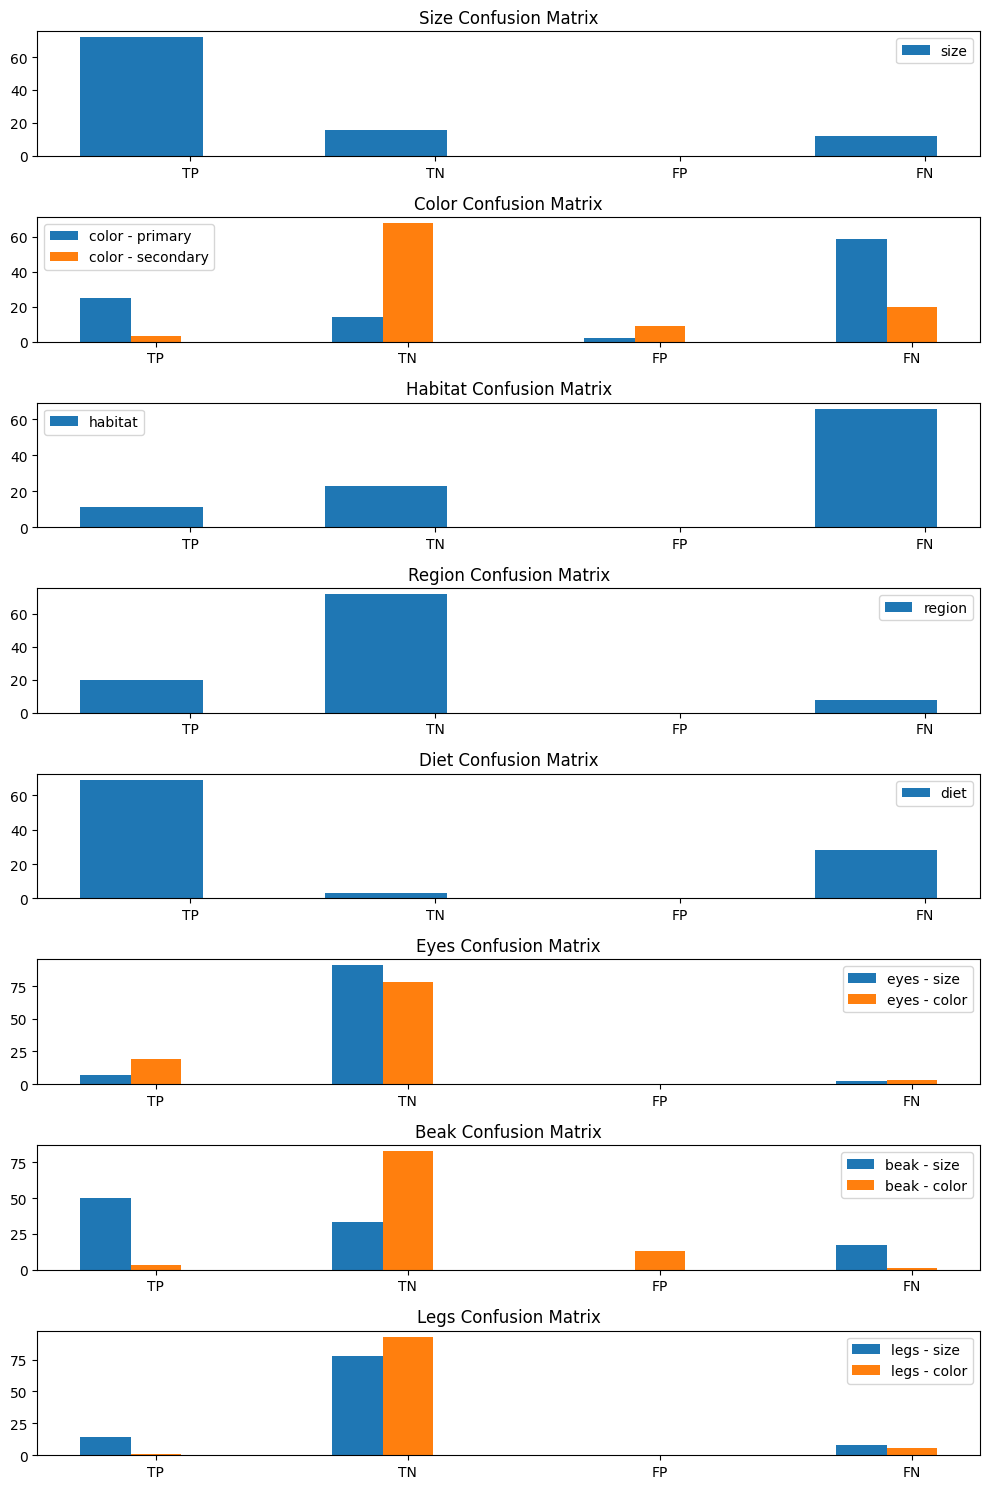

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_results():
    # Run the advanced evaluation function and get the results
    results = advanced_evaluation()

    # Create subplots for each feature category
    fig, axes = plt.subplots(len(results), 1, figsize=(10, 15))

    # If there's only one axis, convert axes to a list for uniformity
    if len(results) == 1:
        axes = [axes]

    # Iterate over each feature and plot the results
    for idx, (feature, metrics) in enumerate(results.items()):
        ax = axes[idx]

        if isinstance(metrics, dict) and not isinstance(list(metrics.values())[0], int):
            # Multiple subcategories (e.g., 'color' with 'primary' and 'secondary')
            categories = list(metrics.keys())
            values = [list(metrics[cat].values()) for cat in categories]
            labels = ['TP', 'TN', 'FP', 'FN']

            # Plot bars for each subcategory
            for i, (cat, value) in enumerate(zip(categories, values)):
                ax.bar(np.arange(4) + i * 0.2, value, width=0.2, label=f'{feature} - {cat}')

        else:
            # Single category (e.g., 'size', 'habitat')
            values = list(metrics.values())
            labels = ['TP', 'TN', 'FP', 'FN']
            ax.bar(np.arange(4), values, width=0.5, label=feature)

        ax.set_title(f'{feature.capitalize()} Confusion Matrix')
        ax.set_xticks(np.arange(4) + 0.2)
        ax.set_xticklabels(labels)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_evaluation_results()


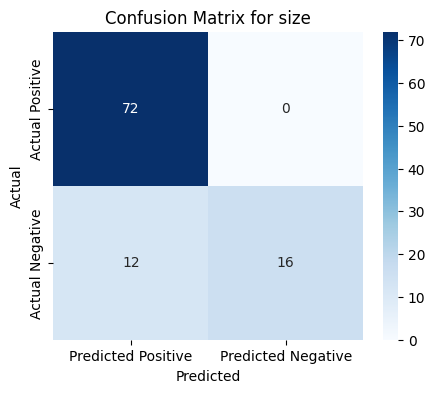

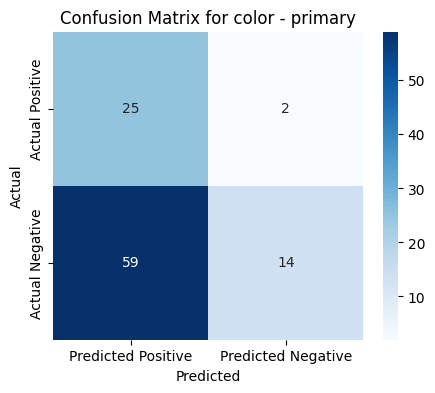

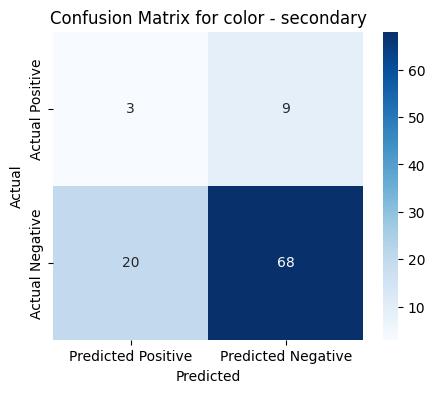

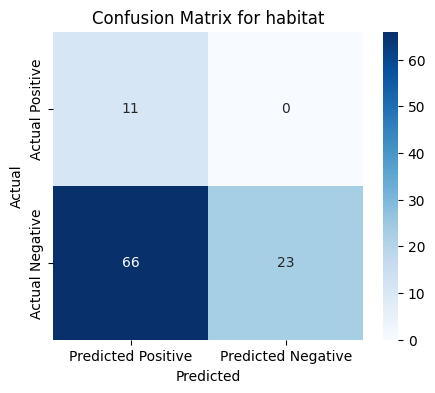

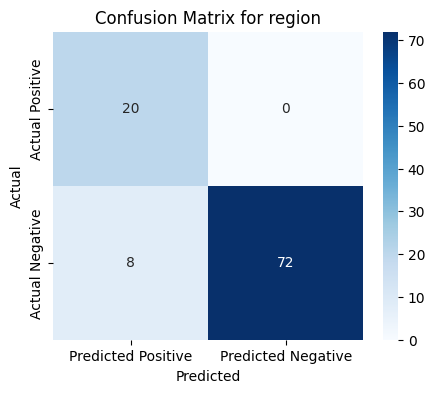

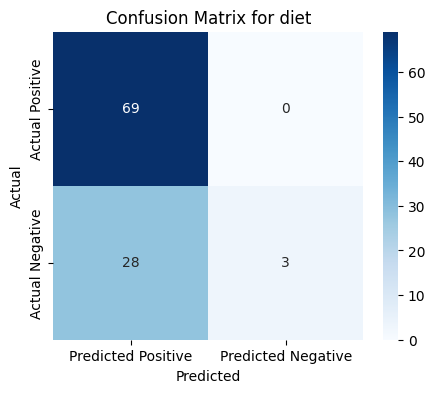

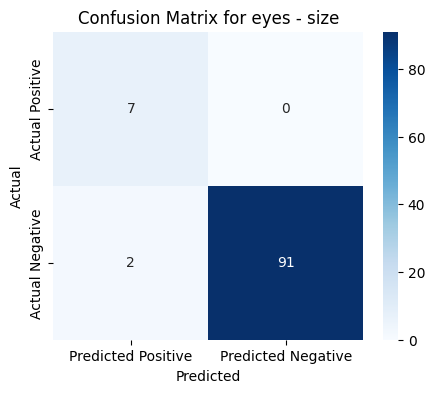

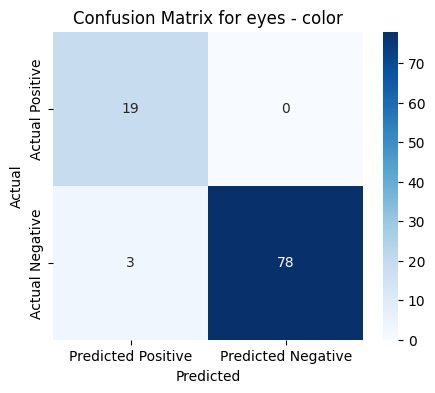

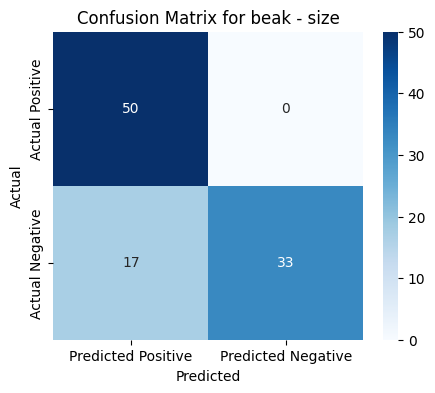

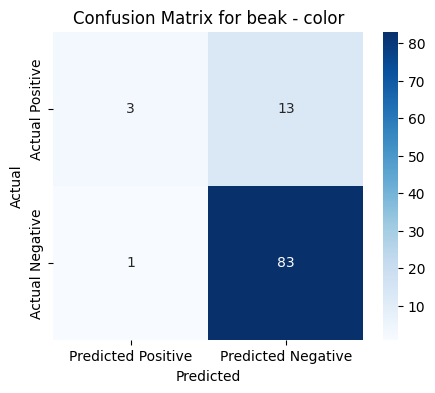

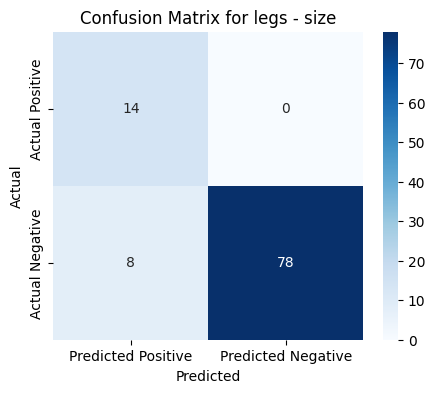

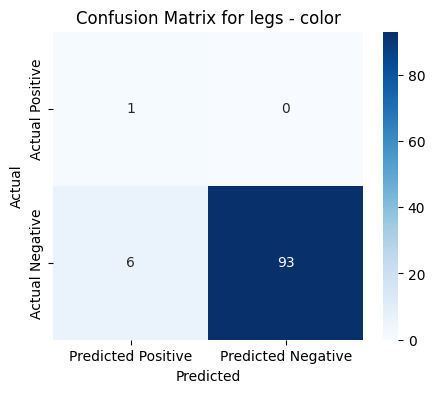

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(evaluation_dict):
    """
    Plot confusion matrices for each feature (size, color, habitat, etc.) from the evaluation results.
    """
    categories = list(evaluation_dict.keys())

    for category in categories:
        category_data = evaluation_dict[category]
        if isinstance(category_data, dict):
            # Check if the category contains subcategories (each value is a dict of metrics)
            # Determine this by checking the type of the first entry's value
            first_key = next(iter(category_data.keys()), None)
            has_subcategories = False
            if first_key is not None:
                first_value = category_data.get(first_key)
                if isinstance(first_value, dict):
                    has_subcategories = True

            if has_subcategories:
                # Process each subcategory under the main category
                for subcategory in category_data:
                    subcategory_data = category_data[subcategory]
                    # Extract TP, FP, FN, TN values
                    matrix = [
                        [subcategory_data.get("TP", 0), subcategory_data.get("FP", 0)],
                        [subcategory_data.get("FN", 0), subcategory_data.get("TN", 0)]
                    ]
                    # Plot confusion matrix
                    plt.figure(figsize=(5, 4))
                    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                                xticklabels=["Predicted Positive", "Predicted Negative"],
                                yticklabels=["Actual Positive", "Actual Negative"])
                    plt.title(f"Confusion Matrix for {category} - {subcategory}")
                    plt.ylabel('Actual')
                    plt.xlabel('Predicted')
                    plt.show()
            else:
                # Process the main category directly as it contains metrics
                matrix = [
                    [category_data.get("TP", 0), category_data.get("FP", 0)],
                    [category_data.get("FN", 0), category_data.get("TN", 0)]
                ]
                # Plot confusion matrix
                plt.figure(figsize=(5, 4))
                sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                            xticklabels=["Predicted Positive", "Predicted Negative"],
                            yticklabels=["Actual Positive", "Actual Negative"])
                plt.title(f"Confusion Matrix for {category}")
                plt.ylabel('Actual')
                plt.xlabel('Predicted')
                plt.show()
        else:
            # Handle cases where the category data is not a dictionary (if applicable)
            print(f"Skipping {category} as it is not a dictionary.")

# Example usage:
evaluation_dict = advanced_evaluation()
plot_confusion_matrices(evaluation_dict)